# Hospital Medical Charges - Bayesian

The hospital is reviewing its financial resiliency plan, which requires a model for revenue under a range of conditions that include the number of patients treated. Its current model is based on a confidence interval for the mean, and scaling that by different numbers of patients for each scenario. This approach has a number of limitations, most acutely the breakdown of the central limit theorem for low patient volumes; the current model does not do a good job of reflecting the variability in revenue you would see as the number of cases drops. A bootstrap approach would return samples of the same size as the original. Taking subsamples would restrict the sampling to the values already present in the original sample and would not do a good job of representing the actual variability you might see. What is needed is a better model of individual charges.

Thus the goal here is to model the distribution of individual charges and _be able to capture our uncertainty about that distribution_ in order to better capture the range of values. This leads us to a powerful, probabilistic approach called Bayesian inference.

### Loading the data and performing an initial view

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

In [2]:
medical = pd.read_csv('data/insurance2.csv')

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

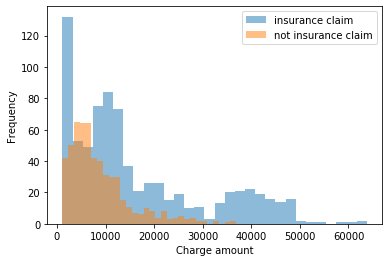

In [5]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

It is suspected from the above that there is some sort of exponential-like distribution at play here. The charges that were not insurance claims seem most like this. The insurance claim charges may possibly be multimodal. The gamma distribution may be applicable and we could test this for the distribution of charges that weren't insurance claims first. Developing our new method for the easiest looking case first is a common and sound approach that can demonstrate a minimum viable solution/product and get, or keep, stakeholders on board.

### Initial parameter estimation

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made as described [here](https://wiki.analytica.com/index.php?title=Gamma_distribution).

In [6]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

### Initial simulation

Drew the same number of random variates from this distribution and compare to our observed data.

In [7]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

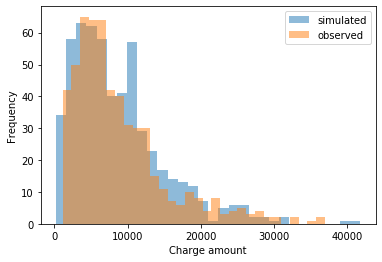

In [8]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

The simulated distribution is not completely off from the observed. This is a plausible form for the distribution of charge amounts and potential values for that distribution's parameters, thus it can already draw random variates from that distribution to perform simulations. It is unknown if this is a _best_ estimate for the population parameters, and it is also only a single estimate each for $\alpha$ and $\beta$; it is not capturing our uncertainty in their values. Below, I try to take a Bayesian inference approach to estimate the parameters... 

### Creating a PyMC3 model

In [9]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then, before that, you need to create those stochastic variables using `pm.Exponential` and the correct parameters.

__A:__

In [10]:
with pm.Model() as no_ins_model:
    alpha_ = pm.Exponential("alpha", 1/alpha_est)   
    rate_ = pm.Exponential("rate", 1/rate_est)
    
# Class pymc3.distributions.continuous.Gamma(alpha=None, beta=None, mu=None, sigma=None, sd=None, *args, **kwargs)¶
    no_insurance_dist = pm.Gamma("no_insurance", alpha=alpha_, beta=rate_, observed=no_insurance)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate, alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:54<00:00, 776.48draws/s] 


#### Exploring the posteriors for $\alpha$ and $\beta$ (from the trace):

**Calculated the 95% credible interval for $\alpha$ and $\beta$.**

In [11]:
# Extract traces of alpha and beta after 'burning' initial traces
burned_trace = trace[5000:]   # burning initial 50% traces

# [] must be equal to the `name` variable
alpha_samples = burned_trace['alpha']
rate_samples = burned_trace['rate']

# From Cell (13) Above 
beta_samples = 1/rate_samples

In [12]:
# 95% Credible Interval
alpha_ci95 = np.percentile(alpha_samples,[2.5, 97.5])
beta_ci95 = np.percentile(beta_samples, [2.5, 97.5])

print("95% Credible interval for alpha is {}".format(alpha_ci95))
print("95% Credible interval for beta (1/rate) is {}".format(beta_ci95))

95% Credible interval for alpha is [1.99087973 2.47970095]
95% Credible interval for beta (1/rate) is [3506.9540103  4494.88649867]


**Plotted posterior values of $\alpha$ and $\beta$ (both line plots and histograms) and marked CIs on the histograms.**

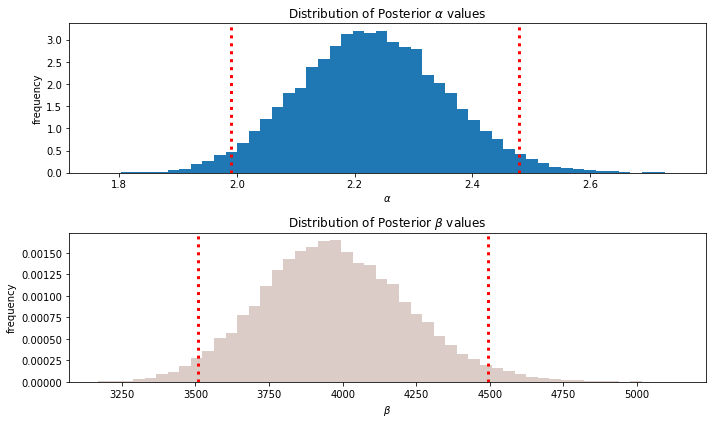

In [13]:
plt.figure(figsize=(10,6))
ax = plt.subplot(211)
_ = plt.hist(alpha_samples, density=True, bins=50)
_ = plt.title("Distribution of Posterior $\\alpha$ values")
_ = plt.xlabel('$\\alpha$')
_ = plt.ylabel('frequency')
_ = plt.axvline(alpha_ci95[0], ls=':', lw=3, color='red')
_ = plt.axvline(alpha_ci95[1], ls=':', lw=3, color='red')

ax = plt.subplot(212)
_ = plt.hist(beta_samples, density=True, bins=50, color='C5', alpha=0.3)
_ = plt.title('Distribution of Posterior $\\beta$ values')
_ = plt.xlabel('$\\beta$')
_ = plt.ylabel('frequency')
_ = plt.axvline(beta_ci95[0], ls=':', lw=3, color='red')
_ = plt.axvline(beta_ci95[1], ls=':', lw=3, color='red')

plt.tight_layout()
plt.show()

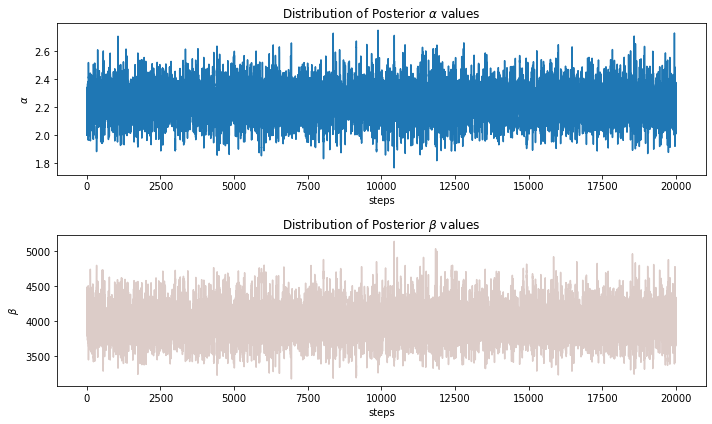

In [14]:
# Lineplots
plt.figure(figsize=(10,6))
ax = plt.subplot(211)
_ = plt.plot(alpha_samples)
_ = plt.title("Distribution of Posterior $\\alpha$ values")
_ = plt.ylabel('$\\alpha$')
_ = plt.xlabel('steps')

ax = plt.subplot(212)
_ = plt.plot(beta_samples, color='C5', alpha=0.3)
_ = plt.title('Distribution of Posterior $\\beta$ values')
_ = plt.ylabel('$\\beta$')
_ = plt.xlabel('steps')


plt.tight_layout()
plt.show()

**Using the the traceplot for alpha and beta:**

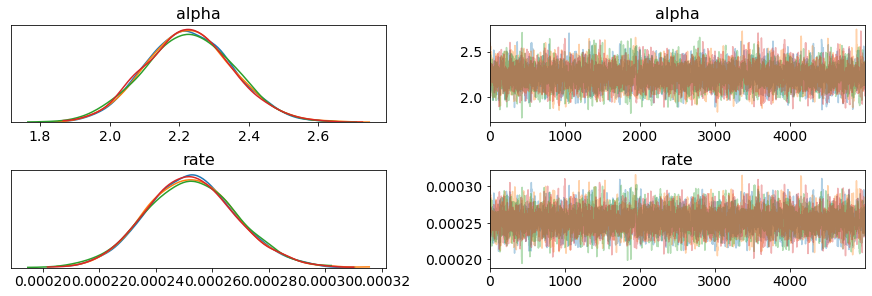

In [18]:
# Traceplots of alpha and rate with pymc.plots
pm.plots.traceplot(burned_trace)
plt.show()

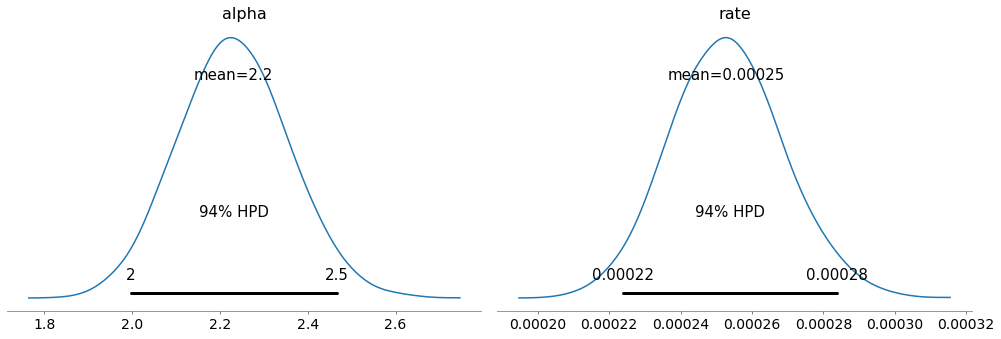

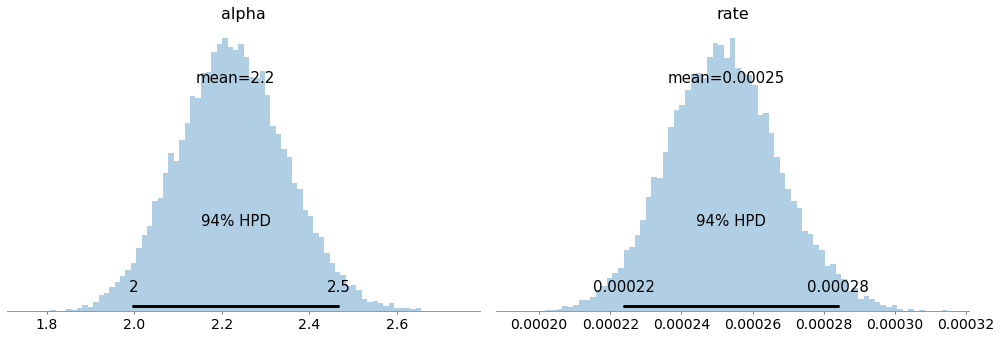

In [19]:
# Plotting the Posterior for alpha and rate (in both distributin and histogram)
pm.plots.plot_posterior(data=burned_trace)
pm.plots.plot_posterior(data=burned_trace, kind='hist')
plt.show()

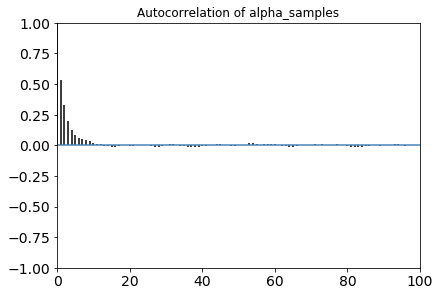

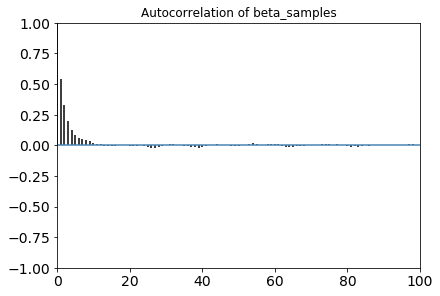

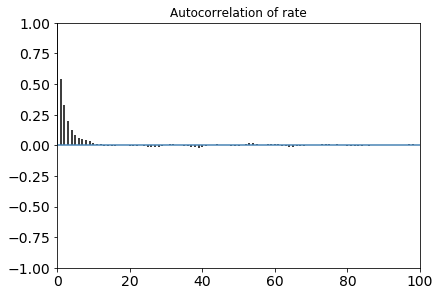

In [20]:
# Plotting autocorrelation
pm.plots.autocorrplot(alpha_samples)
plt.title('Autocorrelation of alpha_samples')
pm.plots.autocorrplot(beta_samples)
plt.title('Autocorrelation of beta_samples')
pm.plots.autocorrplot(rate_samples)
plt.title('Autocorrelation of rate')
plt.show()

#### Conclusions:
* Trace seems to settle down along the x-axis, suggesting that there is autocorrelation and that MCMC has converged.
* The histograms look normally distributed.
* The lineplots of alpha and rate above look random but from the plot above it conveys an autocorrelation.

##### Simulated sequence of medical charges using scipy.stat's gamma distribution. Simulated a data set with the same size as the number of observations in the data and overlay the two histograms (simulated and observed): 

In [24]:
gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

array([26679.29714809,  1633.78318364,  5316.80298157,   766.93179963,
        4317.52435303,  6908.41351438,  5437.38536801,  5913.73664377,
       23335.66607805, 19635.42700598, 19126.60135858,  2145.64169371,
        6849.84056221,   731.06687394,  2970.06120543,  8624.68422576,
        7482.99687454,  6857.3147199 , 10299.50902876,  2790.11184585,
        4057.86086024, 10051.4064459 ,  6784.54274889, 17247.14106118,
        4422.8300748 ,  3135.14806218, 12529.69777806,  8826.6026606 ,
        6967.67755259,  5195.25041161,  2580.92213894,  6778.66857959,
        6716.93108962, 18132.9585619 ,  1606.41340803,  2470.85613328,
        8735.31143557,  7078.43919961,   761.42537594,  1391.8880847 ,
        3257.55214108,  4520.36938842,  6872.44472023,  9362.74495973,
        4095.33675647,  6683.30838915, 12700.84300969,  7807.39611985,
        1484.06027512, 32262.5551646 , 13700.49613842,  5479.04663232,
        6986.40948854,  6312.83154961,  7848.49068095, 13218.0628024 ,
      

In [26]:
seed(47)
best_shot_simulated = gamma(np.mean(alpha_samples), scale=np.mean(beta_samples)).rvs(n_no_ins)

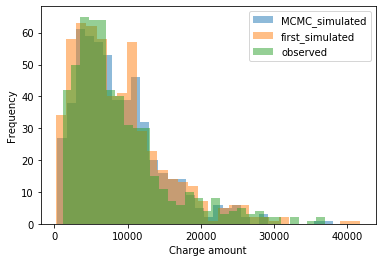

In [27]:
_ = plt.hist(best_shot_simulated, bins=30, alpha=0.5, label='MCMC_simulated')
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='first_simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

# Compare the below histogram with the first gamma simulation performed above
# (no_ins_model_rvs)
# Right now all three histograms overlaid together

#### Conclusion:
Just by looking at the visualizations, it looks like the MCMC simulation simulates the observed data more closely compared to the first simulation.